In [436]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle as pk


In [437]:
# Load your dataset (adjust the path if needed)
df = pd.read_csv('all_data.csv')
# Set the Date column as the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [438]:
df

,crude_oil_Price,crude_oil_Open,crude_oil_High,crude_oil_Low,crude_oil_Vol.,crude_oil_Change %,gold_Open,gold_High,gold_Low,gold_Close,...,silver_Change %,dollar_rate_Price,dollar_rate_Open,dollar_rate_High,dollar_rate_Low,dollar_rate_Change %,cpi_CPI,ppi_PPI,m1sl_M1SL,is_holiday
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-01,98.70,98.61,98.76,98.54,NaN,0.28,NaN,NaN,NaN,NaN,...,NaN,80.03,80.21,80.24,80.10,0.00,234.100,201.200,2638.8,1
2014-01-02,95.44,98.50,98.97,95.34,251250.0,-3.30,117.930000,118.730003,117.750000,118.000000,...,3.91,80.63,80.12,80.71,80.08,0.75,234.100,201.200,2638.8,0
2014-01-03,93.96,95.47,95.74,93.86,215520.0,-1.55,118.639999,119.620003,118.589996,119.290001,...,0.41,80.79,80.57,80.89,80.49,0.20,234.100,201.200,2638.8,0
2014-01-06,93.43,94.18,94.59,93.20,189380.0,-0.56,119.760002,120.389999,117.110001,119.500000,...,-0.53,80.65,80.86,80.91,80.54,-0.17,234.100,201.200,2638.8,0
2014-01-07,93.67,93.60,94.22,93.35,177180.0,0.26,118.459999,118.919998,118.129997,118.820000,...,-1.57,80.83,80.69,80.95,80.60,0.22,234.100,201.200,2638.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-26,75.56,77.28,77.69,75.52,365120.0,-2.21,233.449997,233.500000,232.059998,232.759995,...,-1.93,104.66,104.37,104.67,104.14,0.27,313.207,256.772,17978.9,0
2024-08-27,75.56,77.28,77.69,75.52,365120.0,-2.21,231.690002,233.470001,231.570007,233.389999,...,-1.93,104.66,104.37,104.67,104.14,0.27,313.207,256.772,17978.9,0
2024-08-28,75.56,77.28,77.69,75.52,365120.0,-2.21,232.000000,232.020004,230.729996,231.750000,...,-1.93,104.66,104.37,104.67,104.14,0.27,313.207,256.772,17978.9,0


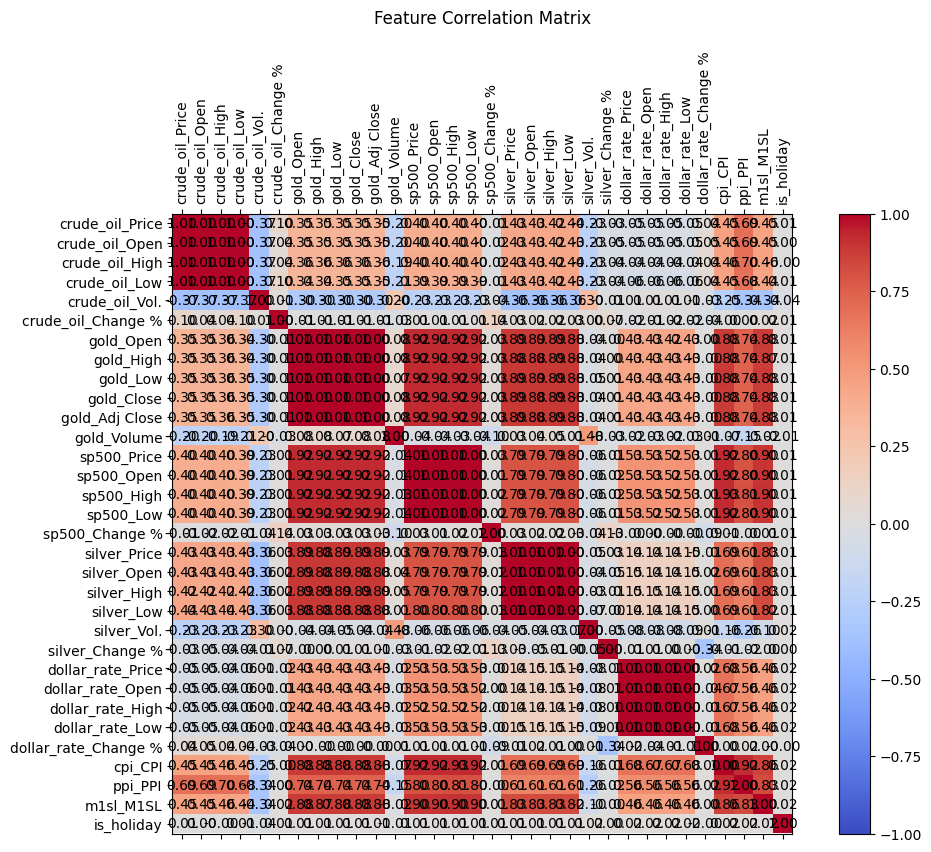

In [439]:
import matplotlib.pyplot as plt

def plot_corr_matrix(df):
    correlation_matrix = df.corr()
    
    # Plotting the correlation matrix with Matplotlib
    plt.figure(figsize=(12, 8))
    plt.matshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, fignum=1)
    plt.colorbar()
    
    # Set tick labels for the correlation matrix
    plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
    plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
    
    # Annotate each cell with the numeric value of the correlation
    for i in range(len(correlation_matrix.columns)):
        for j in range(len(correlation_matrix.columns)):
            plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}", ha='center', va='center', color='black')
    
    plt.title("Feature Correlation Matrix", pad=20)
    plt.show()

plot_corr_matrix(df)

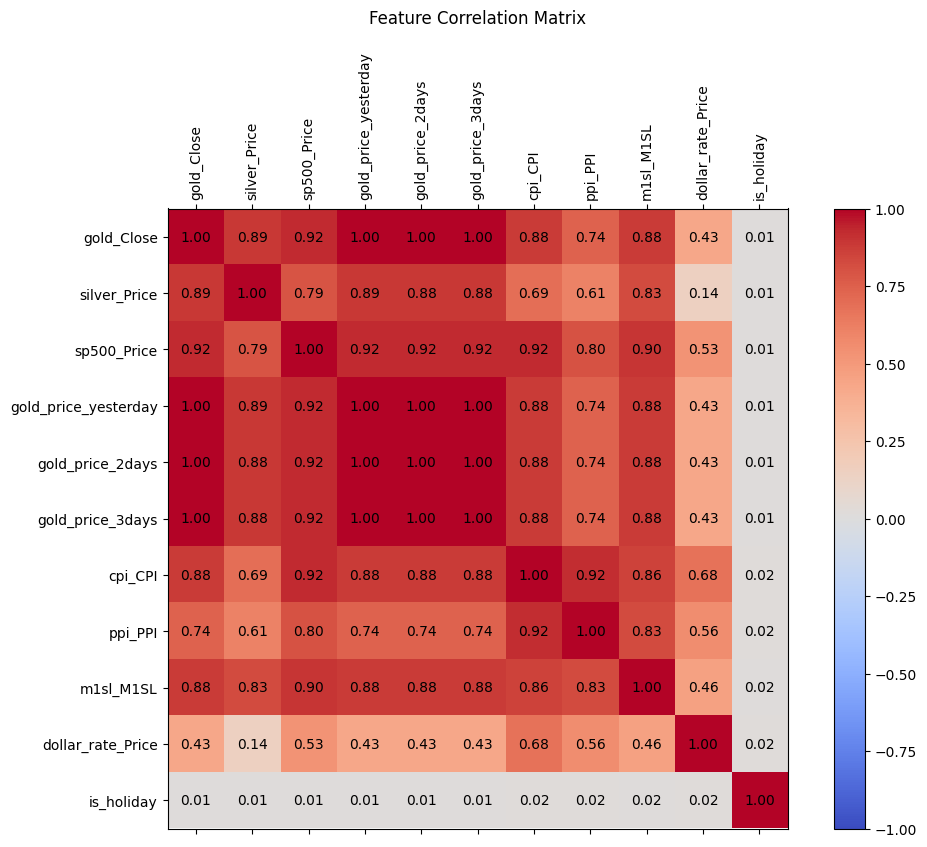

In [440]:
df['gold_price_yesterday'] = df['gold_Close'].shift(1)
df['gold_price_2days'] = df['gold_Close'].shift(2)
df['gold_price_3days'] = df['gold_Close'].shift(3)
df = df[['gold_Close', 'silver_Price', 'sp500_Price','gold_price_yesterday', 'gold_price_2days', 'gold_price_3days','cpi_CPI', 'ppi_PPI', 'm1sl_M1SL', 'dollar_rate_Price','is_holiday']]
plot_corr_matrix(df)

In [441]:
# adding columns to predict - dependent on number of days
df = df[['gold_Close', 'silver_Price', 'sp500_Price','gold_price_yesterday', 'gold_price_2days', 'gold_price_3days','cpi_CPI', 'ppi_PPI', 'm1sl_M1SL', 'dollar_rate_Price','is_holiday']]
num_days = 5 # Number of days to predict
# Prepare target columns for x-day predictions
for i in range(1, num_days + 1):
    df[f'target_day_{i}'] = df['gold_Close'].shift(-i)

# Drop rows with NaN values from shifting
df = df.dropna()
# Separate features and targets
# filter df to leave only 1 column of each type
X = df.drop(columns=[f'target_day_{i}' for i in range(1, num_days + 1)])
y = df[[f'target_day_{i}' for i in range(1, num_days + 1)]]
df

,gold_Close,silver_Price,sp500_Price,gold_price_yesterday,gold_price_2days,gold_price_3days,cpi_CPI,ppi_PPI,m1sl_M1SL,dollar_rate_Price,is_holiday,target_day_1,target_day_2,target_day_3,target_day_4,target_day_5
Date,,,,,,,,,,,,,,,,
2014-01-07,118.820000,19.787,1837.90,119.500000,119.290001,118.000000,234.100,201.200,2638.8,80.83,0,118.120003,118.459999,120.260002,121.019997,119.889999
2014-01-08,118.120003,19.539,1837.50,118.820000,119.500000,119.290001,234.100,201.200,2638.8,81.02,0,118.459999,120.260002,121.019997,119.889999,119.660004
2014-01-09,118.459999,19.683,1838.10,118.120003,118.820000,119.500000,234.100,201.200,2638.8,81.00,0,120.260002,121.019997,119.889999,119.660004,119.790001
2014-01-10,120.260002,20.223,1842.40,118.459999,118.120003,118.820000,234.100,201.200,2638.8,80.66,0,121.019997,119.889999,119.660004,119.790001,120.930000
2014-01-13,121.019997,20.385,1819.20,120.260002,118.459999,118.120003,234.100,201.200,2638.8,80.51,0,119.889999,119.660004,119.790001,120.930000,120.930000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-19,231.610001,27.715,5472.73,231.990005,226.910004,226.199997,313.207,256.772,17978.9,104.66,0,232.460007,232.149994,229.369995,232.020004,232.759995
2024-08-20,232.460007,27.715,5472.73,231.610001,231.990005,226.910004,313.207,256.772,17978.9,104.66,0,232.149994,229.369995,232.020004,232.759995,233.389999
2024-08-21,232.149994,27.715,5472.73,232.460007,231.610001,231.990005,313.207,256.772,17978.9,104.66,0,229.369995,232.020004,232.759995,233.389999,231.750000


In [442]:
# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train_dropped = X_train.dropna()
#print(len(X_train_dropped))
y_train_dropped = y_train.loc[X_train_dropped.index]

# Drop rows with NaN in X_test and y_test
X_test_dropped = X_test.dropna()
y_test_dropped = y_test.loc[X_test_dropped.index]

# Ensure that y_test_dropped does not contain NaN values
X_test_dropped = X_test_dropped.dropna()
y_test_dropped = y_test_dropped.dropna()

# Check if indices still match after dropping NaNs
common_index = X_test_dropped.index.intersection(y_test_dropped.index)
X_test_dropped = X_test_dropped.loc[common_index]
y_test_dropped = y_test_dropped.loc[common_index]

print(y_train_dropped)

            target_day_1  target_day_2  target_day_3  target_day_4  \
Date                                                                 
2014-01-07    118.120003    118.459999    120.260002    121.019997   
2014-01-08    118.459999    120.260002    121.019997    119.889999   
2014-01-09    120.260002    121.019997    119.889999    119.660004   
2014-01-10    121.019997    119.889999    119.660004    119.790001   
2014-01-13    119.889999    119.660004    119.790001    120.930000   
...                  ...           ...           ...           ...   
2022-07-11    160.830002    161.600006    159.330002    159.009995   
2022-07-12    161.600006    159.330002    159.009995    159.160004   
2022-07-13    159.330002    159.009995    159.160004    159.539993   
2022-07-14    159.009995    159.160004    159.539993    158.039993   
2022-07-15    159.160004    159.539993    158.039993    160.270004   

            target_day_5  
Date                      
2014-01-07    119.889999  
2014-01-

In [443]:
y_test_dropped

,target_day_1,target_day_2,target_day_3,target_day_4,target_day_5
Date,,,,,
2022-07-18,159.539993,158.039993,160.270004,160.669998,160.229996
2022-07-19,158.039993,160.270004,160.669998,160.229996,160.039993
2022-07-20,160.270004,160.669998,160.229996,160.039993,161.669998
2022-07-21,160.669998,160.229996,160.039993,161.669998,163.639999
2022-07-22,160.229996,160.039993,161.669998,163.639999,164.100006
...,...,...,...,...,...
2024-08-19,232.460007,232.149994,229.369995,232.020004,232.759995
2024-08-20,232.149994,229.369995,232.020004,232.759995,233.389999
2024-08-21,229.369995,232.020004,232.759995,233.389999,231.750000


In [444]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor

# Fit the MultiOutputRegressor
model = MultiOutputRegressor(LinearRegression())
#model = LinearRegression()
model.fit(X_train_dropped, y_train_dropped)

# Initialize list to hold summary data for each target day
summary_data = []

# Extract feature names from X_train_dropped
feature_names = X_train_dropped.columns

# For each target day, get the model's coefficients, intercept, and performance metrics
for day_index, estimator in enumerate(model.estimators_):
    # Get coefficients as a Series with feature names
    coefficients = pd.Series(estimator.coef_, index=feature_names)
    intercept = estimator.intercept_
    
    # Calculate predictions and performance metrics
    y_pred = estimator.predict(X_train_dropped)
    mse = mean_squared_error(y_train_dropped.iloc[:, day_index], y_pred)
    r2 = r2_score(y_train_dropped.iloc[:, day_index], y_pred)

    # Create a DataFrame for the day's coefficients with metrics included
    day_summary = pd.DataFrame({
        'Coefficient': coefficients,
        'Intercept': intercept,
        'MSE': mse,
        'R^2': r2,
    })
    summary_data.append(day_summary)

# Concatenate all day summaries into a single DataFrame for display
summary_df = pd.concat(summary_data, keys=[f'Target Day {i+1}' for i in range(len(summary_data))])

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Show the full summary with feature names and coefficients
print("Detailed Coefficients Summary for Each Target Day:")
#print(summary_df)

# Reset display options to default after viewing if needed
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
summary_df

Detailed Coefficients Summary for Each Target Day:


Coefficient  Intercept       MSE       R^2
Target Day 1 gold_Close               1.016688   4.434857  1.471160  0.997398
             silver_Price            -0.090509   4.434857  1.471160  0.997398
             sp500_Price              0.000095   4.434857  1.471160  0.997398
             gold_price_yesterday    -0.034327   4.434857  1.471160  0.997398
             gold_price_2days         0.025811   4.434857  1.471160  0.997398
             gold_price_3days        -0.006995   4.434857  1.471160  0.997398
             cpi_CPI                 -0.001592   4.434857  1.471160  0.997398
             ppi_PPI                 -0.006913   4.434857  1.471160  0.997398
             m1sl_M1SL                0.000043   4.434857  1.471160  0.997398
             dollar_rate_Price       -0.017607   4.434857  1.471160  0.997398
             is_holiday              -0.056317   4.434857  1.471160  0.997398
Target Day 2 gold_Close               0.996029   8.097077  2.949649  0.994785
             silver_Price            -0.172831   8.097077  2.949649  0.994785
             sp500_Price              0.000142   8.097077  2.949649  0.994785
             gold_price_yesterday    -0.007197   8.097077  2.949649  0.994785
             gold_price_2days        -0.000369   8.097077  2.949649  0.994785
             gold_price_3days         0.012654   8.097077  2.949649  0.994785
             cpi_CPI                  0.001935   8.097077  2.949649  0.994785
             ppi_PPI                 -0.014996   8.097077  2.949649  0.994785
             m1sl_M1SL                0.000085   8.097077  2.949649  0.994785
             dollar_rate_Price       -0.036501   8.097077  2.949649  0.994785
             is_holiday               0.051168   8.097077  2.949649  0.994785
Target Day 3 gold_Close               1.001668  12.229318  4.318004  0.992367
             silver_Price            -0.263297  12.229318  4.318004  0.992367
             sp500_Price              0.000190  12.229318  4.318004  0.992367
             gold_price_yesterday    -0.029069  12.229318  4.318004  0.992367
             gold_price_2days        -0.022978  12.229318  4.318004  0.992367
             gold_price_3days         0.053103  12.229318  4.318004  0.992367
             cpi_CPI                  0.003100  12.229318  4.318004  0.992367
             ppi_PPI                 -0.022786  12.229318  4.318004  0.992367
             m1sl_M1SL                0.000129  12.229318  4.318004  0.992367
             dollar_rate_Price       -0.055687  12.229318  4.318004  0.992367
             is_holiday               0.147425  12.229318  4.318004  0.992367
Target Day 4 gold_Close               0.984664  16.336058  5.652133  0.990012
             silver_Price            -0.357285  16.336058  5.652133  0.990012
             sp500_Price              0.000227  16.336058  5.652133  0.990012
             gold_price_yesterday    -0.052768  16.336058  5.652133  0.990012
             gold_price_2days         0.022589  16.336058  5.652133  0.990012
             gold_price_3days         0.050116  16.336058  5.652133  0.990012
             cpi_CPI                  0.004716  16.336058  5.652133  0.990012
             ppi_PPI                 -0.030477  16.336058  5.652133  0.990012
             m1sl_M1SL                0.000174  16.336058  5.652133  0.990012
             dollar_rate_Price       -0.075529  16.336058  5.652133  0.990012
             is_holiday               0.318936  16.336058  5.652133  0.990012
Target Day 5 gold_Close               0.941231  19.812088  6.904991  0.987803
             silver_Price            -0.440248  19.812088  6.904991  0.987803
             sp500_Price              0.000263  19.812088  6.904991  0.987803
             gold_price_yesterday    -0.004219  19.812088  6.904991  0.987803
             gold_price_2days         0.001348  19.812088  6.904991  0.987803
             gold_price_3days         0.067182  19.812088  6.904991  0.987803
             cpi_CPI                  0.008670  19.812088

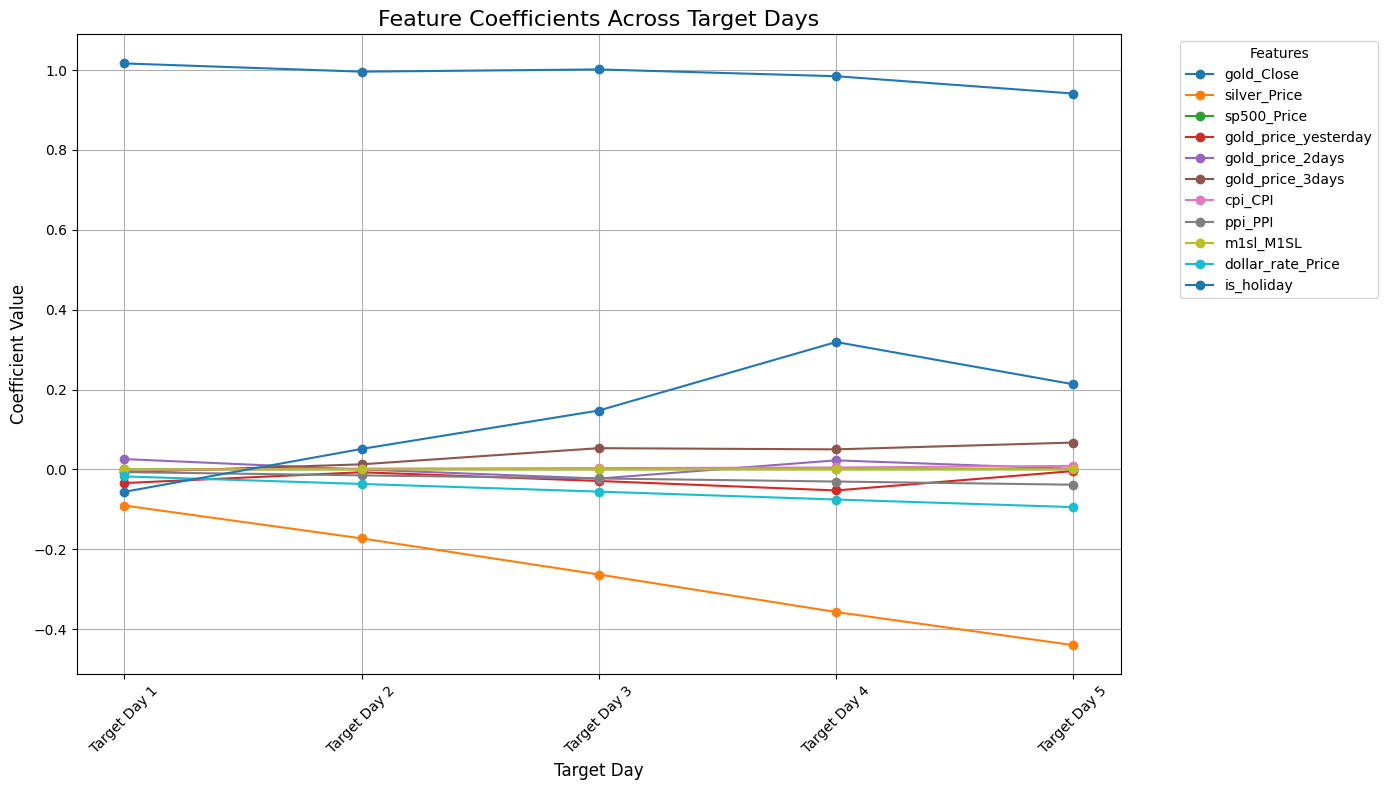

In [451]:
import matplotlib.pyplot as plt

# Create a DataFrame to store the coefficients for each target day
coefficients_df = pd.DataFrame()

# Loop through each day's model and extract the coefficients for the relevant features
for day_index, estimator in enumerate(model.estimators_):
    # Get coefficients as a Series with feature names
    coefficients = pd.Series(estimator.coef_, index=feature_names)
    
    # Add the coefficients for the target day to the DataFrame
    coefficients_df[f'Target Day {day_index + 1}'] = coefficients

# Plot the coefficients for each feature across target days
plt.figure(figsize=(14, 8))

# Loop over the rows (features) and plot them
for feature in coefficients_df.index:
    plt.plot(coefficients_df.columns, coefficients_df.loc[feature, :], label=feature, marker='o')

# Add labels and title
plt.title('Feature Coefficients Across Target Days', fontsize=16)
plt.xlabel('Target Day', fontsize=12)
plt.ylabel('Coefficient Value', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Features', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()


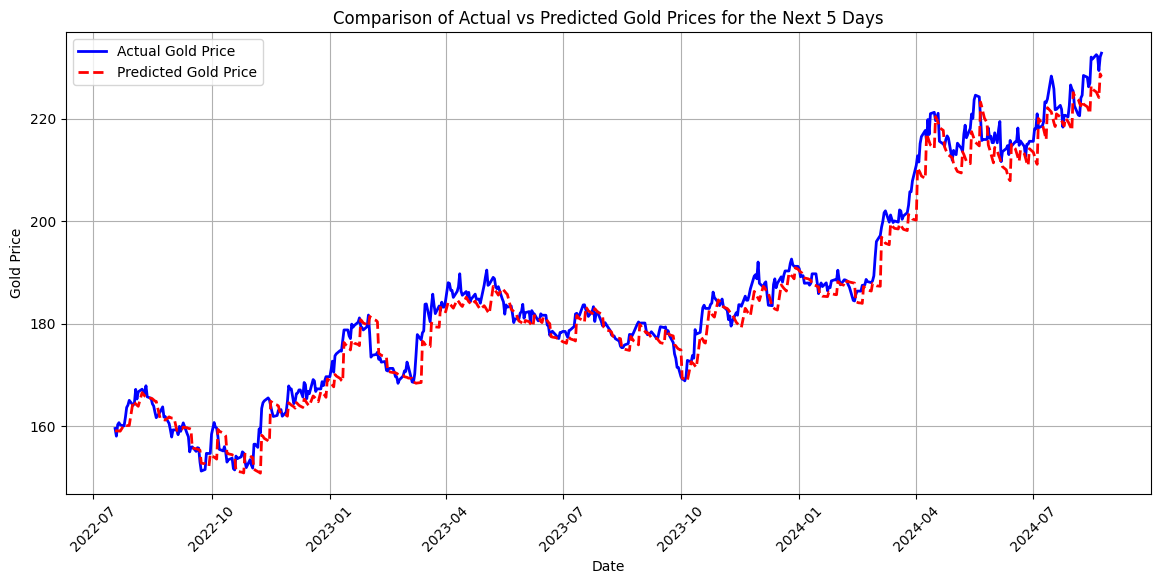

In [446]:
import matplotlib.pyplot as plt
import pandas as pd
model = MultiOutputRegressor(LinearRegression())
model.fit(X_train_dropped, y_train_dropped)
predictions = model.predict(X_test_dropped)

def plot_results(predictions, num_of_days=6):
    # Extract the actual values for the test period (y_test_dropped)
    actual_values = y_test_dropped.iloc[:, 0].values  # Assuming first column has actual values (e.g., 'target_day_1')
    actual_dates = y_test_dropped.index

    # Prepare lists for concatenating predicted values and corresponding dates
    predicted_values = []
    predicted_dates = []
    predictions_df = pd.DataFrame(predictions, index=y_test_dropped.index, 
                                  columns=[f'predicted_day_{i+1}' for i in range(predictions.shape[1])])

    # Create the plot for actual values
    plt.figure(figsize=(14, 6))
    plt.plot(actual_dates, actual_values, label='Actual Gold Price', color='blue', linewidth=2)
    true_values_length = len(y_test_dropped)
    # Loop through the predictions and plot them in chunks of `num_of_days`
    for i in range(0, len(predictions_df), num_of_days):
        # Check if this chunk is smaller than num_of_days
        end_index = min(i + num_of_days, len(predictions_df))
        # Take the current chunk, ensuring we don't go out of bounds
        predicted_chunk = predictions_df.iloc[i, :]  # Grab the chunk (first row if it's the first row)
        # Add to the list of predicted values
        predicted_values.extend(predicted_chunk.values.flatten())  # Flatten to avoid nested lists
        predicted_dates.extend(y_test_dropped.index[i:end_index])
    predicted_values = predicted_values[:true_values_length]
    predicted_dates = predicted_dates[:true_values_length]

    # Plot the predicted values as a single line
    plt.plot(predicted_dates, predicted_values, label='Predicted Gold Price', color='red', linestyle='--', linewidth=2)
    
    plt.title(f'Comparison of Actual vs Predicted Gold Prices for the Next {num_of_days} Days')
    plt.xlabel('Date')
    plt.ylabel('Gold Price')
    plt.legend(loc='upper left')
    
    plt.xticks(rotation=45)  # Rotate x-axis labels for readability
    plt.grid()
    plt.show()
plot_results(predictions, num_of_days=num_days)


In [447]:
predictions

array([[159.08651465, 159.06170824, 159.08183832, 159.03281113,
        159.01444615],
       [159.50904951, 159.47262292, 159.43686545, 159.39960565,
        159.3675651 ],
       [157.9763271 , 157.96820255, 157.89685652, 157.88104995,
        157.92091669],
       ...,
       [231.50979142, 230.95443445, 230.35692102, 229.73109066,
        229.26065845],
       [228.71863892, 228.18258263, 227.54158512, 227.01024167,
        226.62096068],
       [231.49435215, 230.85294653, 230.32908934, 229.8019015 ,
        229.18364821]])

In [448]:
def plot_results(predictions, num_of_days=5):
    # Ensure predictions has the correct shape
    if predictions.shape[1] != num_of_days:
        raise ValueError(f"Predictions must have {num_of_days} columns for each predicted day.")
    
    # Create DataFrames for actual target values (from y_train_dropped and y_test_dropped)
    train_df = pd.DataFrame(y_train_dropped, index=X_train_dropped.index, 
                            columns=[f'target_day_{i+1}' for i in range(y_train_dropped.shape[1])])
    test_df = pd.DataFrame(y_test_dropped, index=X_test_dropped.index, 
                           columns=[f'target_day_{i+1}' for i in range(y_test_dropped.shape[1])])

    # Combine the train and test actual values into one DataFrame
    combined_actual_df = pd.concat([train_df, test_df], axis=0)

    # Create a DataFrame for predictions
    predictions_df = pd.DataFrame(predictions, index=y_test_dropped.index, 
                                  columns=[f'predicted_day_{i+1}' for i in range(predictions.shape[1])])


    # Initialize the plot
    plt.figure(figsize=(14, 6))

    # Plot the actual values (target_day_1 to target_day_num_of_days)
    actual_line = combined_actual_df.iloc[:, 0]  # Use target_day_1 for actual values
    plt.plot(actual_line.index, actual_line, label='Actual Gold Price', color='blue', linewidth=2)

    # Create a list to store the predicted values in chunks
    predicted_values = []
    predicted_dates = []

    # For each day to predict, get predictions for the next `num_of_days`
    for i in range(0, len(predictions_df), num_of_days):
        predicted_chunk = predictions_df.iloc[i:i+num_of_days, 0]  # Grab the next `num_of_days` predictions
        predicted_values.extend(predicted_chunk)  # Add to the list of predicted values
        predicted_dates.extend(y_test_dropped.index[i:i+num_of_days])  # Use correct range of dates

    print(len(predicted_values))

    # Plot the concatenated predicted line (as chunks of `num_of_days`)
    plt.plot(predicted_dates, predicted_values, label='Predicted Gold Price', color='red', linewidth=2)

    # Configure plot appearance
    plt.title(f'Comparison of Actual vs Predicted Gold Prices for the Next {num_of_days} Days')
    plt.xlabel('Date')
    plt.ylabel('Gold Price')
    plt.legend(loc='upper left')
    plt.xticks(rotation=45)  # Rotate x-axis labels for readability
    plt.grid()

    # Set the x-axis limit to only show dates from 2022 onward
    plt.xlim([pd.Timestamp('2022-01-01'), combined_actual_df.index.max()])

    plt.show()

    
plot_results(predictions, num_of_days=30)

ValueError: Predictions must have 30 columns for each predicted day.

In [ ]:
df


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate performance metrics
rmse = np.sqrt(mean_squared_error(y_test_dropped, predictions))
mae = mean_absolute_error(y_test_dropped, predictions)
r2 = r2_score(y_test_dropped, predictions)

print(f"Root Mean Square Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.2f}")

# Plot residuals
residuals = y_test_dropped - predictions
plt.figure(figsize=(12, 6))
plt.scatter(y_test_dropped.index, residuals, color='purple')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('Residuals Plot')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.xticks(rotation=45)
plt.grid()
plt.show()


In [ ]:
import statsmodels.api as sm

# Add a constant term to the model (intercept)
X_train_dropped = sm.add_constant(X_train_dropped)
X_test_dropped = sm.add_constant(X_test_dropped)

# Fit the model using statsmodels OLS (Ordinary Least Squares)
model = sm.OLS(y_train_dropped, X_train_dropped).fit()

# Print out the summary of the model
print(model.summary())


In [ ]:
# Lasso Regression - Feature Selection
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Assuming you have already created X_train_dropped, X_test_dropped, y_train_dropped, y_test_dropped

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_dropped)
X_test_scaled = scaler.transform(X_test_dropped)

# Initialize the Lasso model with a chosen alpha (regularization strength)
alpha = 0.1  # You may need to adjust this value
lasso_model = Lasso(alpha=alpha)

# Fit the Lasso model
lasso_model.fit(X_train_scaled, y_train_dropped)

# Predictions
y_pred = lasso_model.predict(X_test_scaled)

# Calculate and print evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_dropped, y_pred))
mae = mean_absolute_error(y_test_dropped, y_pred)

print(f"Root Mean Square Error: {rmse}")
print(f"Mean Absolute Error: {mae}")

# Get the coefficients and the corresponding feature names
coef = pd.Series(lasso_model.coef_, index=X_train_dropped.columns)
print("Lasso Coefficients:")
print(coef[coef != 0])  # Print only significant features (non-zero coefficients)

# Optional: Plot the coefficients
plt.figure(figsize=(10, 6))
coef.plot(kind='bar')
plt.title('Lasso Coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.show()


In [ ]:
X_train_dropped = X_train.dropna()
y_train_dropped = y_train[X_train_dropped.index]

# Drop rows with NaN in X_test and y_test
X_test_dropped = X_test.dropna()
y_test_dropped = y_test.loc[X_test_dropped.index]  # Drop NaNs based on indices in X_test_dropped

# Ensure that y_test_dropped does not contain NaN values
X_test_dropped = X_test_dropped.dropna()
y_test_dropped = y_test_dropped.dropna()

# Check if indices still match after dropping NaNs
common_index = X_test_dropped.index.intersection(y_test_dropped.index)
X_test_dropped = X_test_dropped.loc[common_index]
y_test_dropped = y_test_dropped.loc[common_index]
# Initialize and train the model
model = LinearRegression()
model.fit(X_train_dropped, y_train_dropped)

# Predict on test data
y_pred = model.predict(X_test_dropped)
pred_index = X_test_dropped.index

# Create a DataFrame for predictions
linear_reg_predictions_df = pd.DataFrame(y_pred, index=pred_index, columns=['Predictions'])
# Assuming test_data is the DataFrame with actual values and it has the same index as X_test_dropped
# Combine predictions and actual test data
test_data = y_test_dropped.to_frame()  # Ensure test_data is a DataFrame
linear_reg_predictions_df = test_data.join(linear_reg_predictions_df)
linear_reg_predictions_df.index = linear_reg_predictions_df.index + pd.DateOffset(days=1)

# Evaluate the model
mse = mean_squared_error(y_test_dropped, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_dropped, y_pred)
mae = mean_absolute_error(y_test_dropped, y_pred)

print("Linear Regression Model Summary")
print(f"Intercept: {model.intercept_}")
print(f"Coefficients: {model.coef_}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

In [ ]:
with open('modelResults/linear_reg_predictions_df', 'wb') as file:
    # Serialize the object and write it to the file
    pkl.dump(linear_reg_predictions_df, file)

In [ ]:
import pandas as pd

# Assuming `gold_prices` is your DataFrame with actual prices and `predictions` is a Series of predicted prices
gold_prices['Returns'] = gold_prices['gold_price'].pct_change()  # Actual returns
predictions['Returns'] = predictions.pct_change()  # Predicted returns
